In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import tqdm.notebook
import sycomore
from sycomore.units import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
r = np.linspace(-0.1, 0.1, 5) * mm
xx, yy = np.meshgrid(r, r)

In [3]:
voxel = np.zeros(xx.shape + (5201,3))

In [4]:
# PCASL: A typical sequence may use 750 0.5 ms, 20◦, Hann RF pulses over a 1500 ms period
length = 1500 # ms
flip_angle = 40*deg
gamma = 42.6e6 * Hz/T # Hz/T
Gamma = gamma * 2 * np.pi * rad # rads/Ts
B1_per_pulse = (20 * np.pi / 180) / (Gamma * 0.5e-3)
B1 = 750 * 0.5 * B1_per_pulse / length # T

In [5]:
dt = 0.1*ms
T1 = 1000*ms
T2 = 200*ms
zero = 0*mT/m
G = 40*mT/m
spoil = 400*mT/m
DeltaT = 2*ms

In [6]:
flowrate = 0.014 # cm/ms
flowffset = 10 # cm
def trajectory(t):
    """
    Return position Time in 
    """
    r = flowrate * t - flowffset
    return r

In [10]:
trajectory(0), trajectory(300), trajectory(1500) # cm

(-10.0, -5.8, 11.0)

In [11]:
aliased_labelling_plane = (1 / (gamma * 1*mT/m * 1 *ms)).convert_to(cm)
aliased_labelling_plane # cm

2.3474178403755865

The flowing spins cross several labelling planes, and therefore are partially inverted multiple times

In [12]:
species = sycomore.Species(T1, T2)

pbar = tqdm.notebook.tqdm(total=xx.size)
for xind, x in enumerate(r):
    for yind, y in enumerate(r):
        pbar.update()

        idle = sycomore.bloch.time_interval(species, dt)
        pulse_20 = sycomore.bloch.pulse(flip_angle)

        t = 0*s
        M = np.array([0,0,1,1])

        record = [[t, M[:3]/M[3]]]
        
        length = 10*ms
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        for i in range(250):
            M = pulse_20 @ M
            # record.append([t, M[:3]/M[3]])

            length = DeltaT
            for _ in range(int(round(length / dt))):
                t = t+dt
                position = [x, y + trajectory(t.convert_to(ms)) * cm] # loop to sim full isochromat within a voxel -> can see echo and spoiler
                grad = sycomore.bloch.time_interval(species, dt, gradient_amplitude=[zero, G], position=position)
                M = grad @ M
                record.append([t, M[:3]/M[3]])

        length = 10 * ms
        for _ in range(int(round(length / dt))):
            t = t+dt
            M = idle @ M
            record.append([t, M[:3]/M[3]])
        
        time, magnetization = list(zip(*record))
        magnetization = np.array(magnetization)
        voxel[xind, yind] = magnetization

  0%|          | 0/25 [00:00<?, ?it/s]

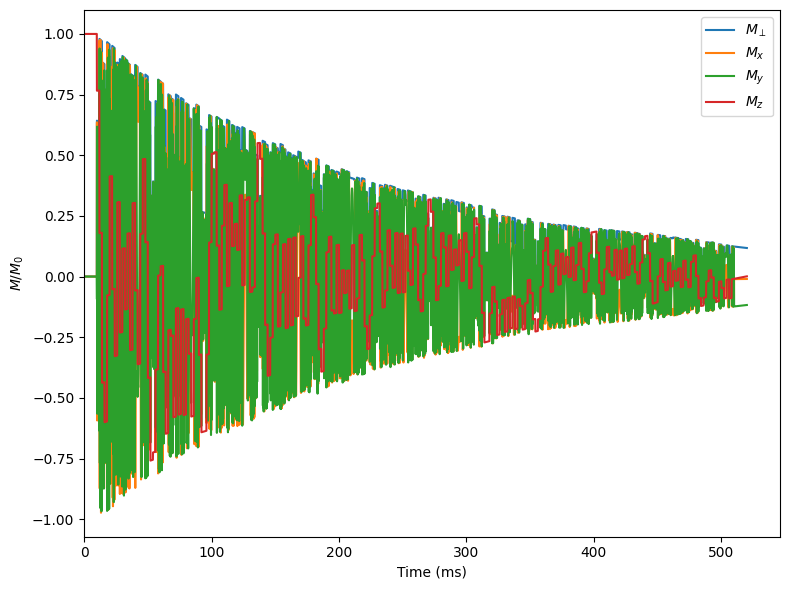

In [13]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(
    x_axis, np.linalg.norm(magnetization[:, :2], axis=-1), label="$M_\perp$")
plt.plot(x_axis, magnetization[:, 0], label="$M_x$")
plt.plot(x_axis, magnetization[:, 1], label="$M_y$")
plt.plot(x_axis, magnetization[:, 2], label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.tight_layout()

In [14]:
transverse_mag = (voxel[..., 0] + 1j * voxel[..., 1]).mean(axis=(0, 1))
longitudinal_mag = voxel[..., 2].mean(axis=(0, 1))

In [15]:
x_axis[longitudinal_mag.argmin()]

50.100000000000406

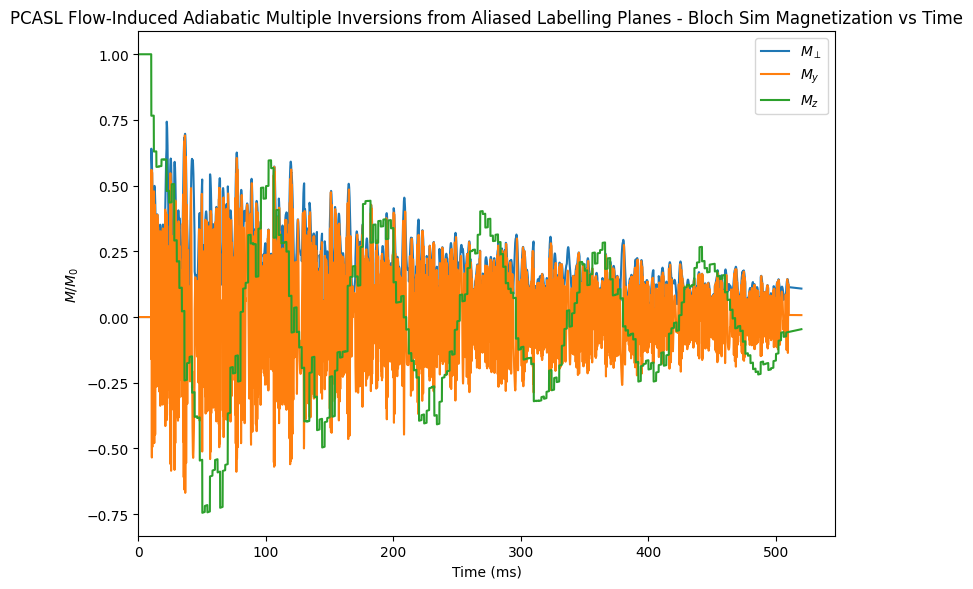

In [17]:
x_axis = [x.convert_to(ms) for x in time]

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_axis, np.abs(transverse_mag), label="$M_\perp$")
# plt.plot(x_axis, transverse_mag.real, label="$M_x$")
plt.plot(x_axis, transverse_mag.imag, label="$M_y$")
plt.plot(x_axis, longitudinal_mag, label="$M_z$")
plt.xlim(0)
plt.xlabel("Time (ms)")
plt.ylabel("$M/M_0$")
plt.legend()
plt.title('PCASL Flow-Induced Adiabatic Multiple Inversions from Aliased Labelling Planes - Bloch Sim Magnetization vs Time')
plt.tight_layout()
plt.savefig('figures/PCASL Flow-Induced Adiabatic Multiple Inversions from Aliased Labelling Planes - Bloch Sim Magnetization vs Time.png')